In [ ]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy

import statsmodels.api as sm

# Functions

In [ ]:
def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    # score = (y - x*f)
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

In [ ]:
def score_compute_2(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f) # ** The 'type = 2' modification **
    
    return score

def filterGAS_2(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute_2(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute_2(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest_2(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS_2(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

In [ ]:
def GAS_est(df):
    
    y = df.net_qty.values          # observed demand (response)
    x = df.buy_availability.values # buy_availability (explanatory)

    y = y.reshape((len(y),1)) 
    x = x.reshape((len(y),1))
    
    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest,                                       # function to minimize (log likelihood y|x,theta)
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
        args=(y, x), 
        options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method='L-BFGS-B', 
        bounds=((0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, None),          # sigma
                (0.001, np.mean(y)*2)   # f
               )
    )
    
    
    # --- CONVERGENCE control flow ---
    if abc.success == True:
        
        x1par = initialize_parameters(abc.x) 
        f_est = filterGAS(y, x, x1par)
        
        ret['f_est'] = f_est 
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['One'] * len(y)
        
    # **Modification if first algorithm fails
    elif abc.success == False:
        
        abc = scipy.optimize.minimize(
            loglikest_2,                                       # function to minimize (log likelihood y|x,theta)
            np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]),   # initial parameter values (starting)
            args=(y, x), 
            options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
            method='L-BFGS-B', 
            bounds=((0,  None),             # alpha
                    (-1, 1),                # beta
                    (0.001, np.mean(y)*2),  # omega 
                    (0.001, None),          # sigma
                    (0.001, np.mean(y)*2)   # f
                   )
                )

        x1par = initialize_parameters(abc.x) 
        f_est = filterGAS_2(y, x, x1par)
        
        ret['f_est'] = f_est 
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['Two'] * len(y)

    return ret

## Data

In [ ]:
dat0 = pd.read_csv('data/ch4k_df_eu.csv')

In [ ]:
ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, # index_col = 0, 
                       error_bad_lines = False,
                      usecols = ['article_no', 'model_no', 'key_cat_desc', 'sports_cat_desc', 'rmh_cat_desc', 
                                 'prod_div_desc', 'prod_grp_desc', 'prod_type_desc']                      
                      )


In [ ]:
dat = dat0.copy()

dat.dropna(inplace = True)
dat = dat[(dat.season_net_qty > 250) &
          (dat.country == 'EU') & 
          (dat.season_net_qty != 0)]

# For constructing seasonality reference by product_type
ref_dat = ref_dat0.copy()
ref_dat = ref_dat.drop_duplicates()[['article_no', 'prod_type_desc']]

dat = pd.merge(dat, ref_dat, left_on='article_number', right_on='article_no', how = 'left')

# For sorting
# key = {'FW16': 1, 'SS17': 2, 'FW17': 3, 'SS18': 4, 'FW18': 5, 'SS19': 6, 'FW19': 7, 'SS20': 8}
# dat['order_key'] = [key[s] for s in dat.season]

In [ ]:
ref_dat.prod_type_desc.isna().mean() # 30% NAs
# pd.crosstab(index = dat['rmh_product_type_descr'], columns = 'count')

dat[dat.prod_type_desc.isna()].shape

dat[~(dat.article_number.isin(ref_dat.article_no))].season.unique()

In [ ]:
# pd.crosstab(index = [dat['year'], dat['season']], columns = 'count')
dat_FW19 = dat[dat.season == 'FW19']

In [ ]:
dat_FW19.shape
len(dat_FW19.article_number.unique()) # 1631 FW19 articles
dat_FW19.head()

In [ ]:
# For progress: add FAKE FW19 data
dat_FW19_sim = dat_FW19.copy()

for i in range(1, 10):
    dat_i = dat_FW19.copy()
    
    dat_i['week'] = 22 + i
    dat_i['net_qty'] = dat_FW19['net_qty'] + np.random.normal(15, 3, 1631)
    dat_i['buy_availability'] = dat_FW19['buy_availability']*np.random.uniform(0.5, 1, 1631)
    dat_i['buy_availability'] = np.where(dat_i['buy_availability'] == 0, 0.5, dat_i['buy_availability'])
    
    dat_FW19_sim = dat_FW19_sim.append(dat_i)

dat_FW19_sim.shape
# dat_FW19_sim.groupby('week')['net_qty'].describe()
# dat_FW19_sim.groupby('week')['buy_availability'].describe()


## Seasonality by product type

In [ ]:
# Calculate weekly means, by category, for well selling articles, pre-FW19
seasonality = pd.DataFrame(
    dat[(dat.season_net_qty > 500) &
        (dat.season.isin(['FW16', 'FW17', 'FW18'])) # just FWs; better regression results I bet
       ].groupby(['prod_type_desc', 'week'])['net_qty'].mean())

seasonality.reset_index(inplace = True)

# Question: is rmh_product_type_descr the right field to use?
# Question: should it be FW18 only?

# pd.crosstab(index = seasonality['prod_type_desc'], columns = 'count')

seasonality.head()

In [ ]:
seasonality.head()

# GAS

In [318]:
# *** USE fake data, for now ***
dat_FW19 = dat_FW19_sim.copy()

In [319]:
# dat_FW19 = dat[dat.season == 'FW19'].copy()

dat_FW19.sort_values(['article_number', 'year', 'week'], inplace = True)
dat_FW19.set_index(['article_number'], inplace = True)

#   --- RANDOM SUBSET OF ARTICLES ---
# a = np.random.choice(dat_FW19.index.unique(), size = 200, replace = False)
# dat_FW19 = dat_FW19.loc[a ,:].copy()
#   ---- ---- ---- ---- ---- ---- 

dat_FW19.reset_index(inplace = True)


In [ ]:
%%time 

dat_GAS = dat_FW19.groupby('article_number').apply(GAS_est)
dat_GAS.reset_index(inplace = True)


In [ ]:
dat_GAS.head()
dat_GAS.shape

dat_FW19.shape
dat_FW19.head()

# pd.crosstab(index = dat_FW19['prod_type_desc'], columns = 'count')

# dat_FW19.prod_type_desc.isna().mean() 

## Combine

In [320]:
dat_FW19 = dat_FW19.merge(
    dat_GAS[['article_number', 'year', 'week', 'f_est']], 
    how = 'left', 
    on = ['article_number', 'year', 'week']
                          ).sort_values(['article_number', 'year', 'week'])

dat_FW19 = dat_FW19[['article_number', 'year', 'week', 'net_qty', 'prod_type_desc', 'f_est', 'buy_availability']]

# seasonality.rename(columns = {'net_qty': 'type_week_avg'}, inplace = True)

# dat_FW19 = pd.DataFrame(pd.merge(dat_FW19, seasonality, how = 'left'))

In [321]:
article_weeks = pd.DataFrame(
    [(a, w) for a in dat_FW19.article_number.unique() for w in range(22, 50)]
).rename(columns = {0: 'article_number', 1: 'week'})

In [322]:
dat_FW19 = pd.merge(dat_FW19, article_weeks, how = 'outer')

In [323]:
dat_FW19.sort_values(['article_number', 'year', 'week'], inplace = True)

In [324]:
dat_FW19['prod_type_desc'] = dat_FW19.groupby('article_number')['prod_type_desc', 'year'].fillna(method='ffill')

In [325]:
dat_FW19.shape
dat_FW19 = pd.merge(dat_FW19, seasonality, how = 'left')

(45668, 7)

In [326]:
dat_FW19.head()

,article_number,year,week,net_qty,prod_type_desc,f_est,buy_availability,type_week_avg
0,019000,2019.0,22.0,2.000000,FOOTBALL SHOES (INDOOR),2.063362,0.960000,8.000000
1,019000,2019.0,23.0,20.688287,FOOTBALL SHOES (INDOOR),23.055774,0.915408,22.600000
2,019000,2019.0,24.0,18.919192,FOOTBALL SHOES (INDOOR),26.792781,0.524754,27.000000
3,019000,2019.0,25.0,17.898445,FOOTBALL SHOES (INDOOR),27.458031,0.893758,30.571429
4,019000,2019.0,26.0,18.024150,FOOTBALL SHOES (INDOOR),27.576457,0.498411,45.571429


## Seasonality Prediction Column

In [327]:
def ols_preds(df):
    
    ret = pd.DataFrame()
    ret['week'] = df['week']
    
    if(df.type_week_avg.isna().mean() == 1):
        ret['preds'] = df['type_week_avg']
        print('Uh oh:', df.article_number.unique())
        return ret
    
    # df.net_qty: only observed weeks
    # df.type_week_avg: all weeks, b/c historical avgs
    # mod = sm.OLS(df.net_qty, df.type_week_avg, missing = 'drop') # drop NAs (unobserved weeks) to fit regression
    
    mod = sm.OLS(df.f_est, df.type_week_avg, missing = 'drop') # drop NAs (unobserved weeks) to fit regression

    mod_fit = mod.fit()
    mod_predict = mod_fit.predict(df.type_week_avg) # predict for all weeks
    
    ret['preds'] = mod_predict
    
    return ret  

In [310]:
# --- ols learning ---
# ols_test = dat_FW19[dat_FW19.article_number == '019000']

# abc = sm.OLS(ols_test.net_qty, ols_test.type_week_avg, missing = 'drop').fit()

# abc.predict()
# abc.predict(ols_test.type_week_avg)

# Troubleshooting
# jammer = dat_FW19[dat_FW19.article_number == 'DP7550']
# jammer.head()

# jammer.type_week_avg.isna().mean() == 1

In [328]:
preds = dat_FW19.groupby(['article_number']).apply(ols_preds)
preds.reset_index(inplace = True)

Uh oh: ['DP7550']
Uh oh: ['DQ3275']
Uh oh: ['DQ3305']
Uh oh: ['DT4821']
Uh oh: ['DT4822']


In [329]:
dat_FW19 = pd.merge(dat_FW19, preds)

In [315]:
dat_FW19.shape
len(dat_FW19.article_number.unique())
dat_FW19


(435, 10)

212

,article_number,year,week,net_qty,prod_type_desc,f_est,buy_availability,type_week_avg,level_1,preds
0,AQ0602,2019.0,24.0,15.359208,FOOTBALL SHOES (STREET),18.984439,0.865667,NaN,898,NaN
1,AQ0602,NaN,49.0,NaN,FOOTBALL SHOES (STREET),NaN,NaN,NaN,923,NaN
2,BA7849,NaN,49.0,NaN,SANDALS,NaN,NaN,NaN,3695,NaN
3,BA7868,NaN,49.0,NaN,SANDALS,NaN,NaN,NaN,3723,NaN
4,BA9281,NaN,49.0,NaN,SANDALS,NaN,NaN,NaN,3807,NaN
5,BA9289,NaN,49.0,NaN,SANDALS,NaN,NaN,NaN,3835,NaN
6,BB7417,2019.0,24.0,21.748505,FOOTBALL SHOES (STREET),31.514868,0.865688,NaN,4286,NaN
7,BB7417,NaN,49.0,NaN,FOOTBALL SHOES (STREET),NaN,NaN,NaN,4311,NaN
8,BB7419,2019.0,24.0,14.696791,FOOTBALL SHOES (STREET),24.860440,0.571310,NaN,4314,NaN
9,BB7419,NaN,49.0,NaN,FOOTBALL SHOES (STREET),NaN,NaN,NaN,4339,NaN


## Plots

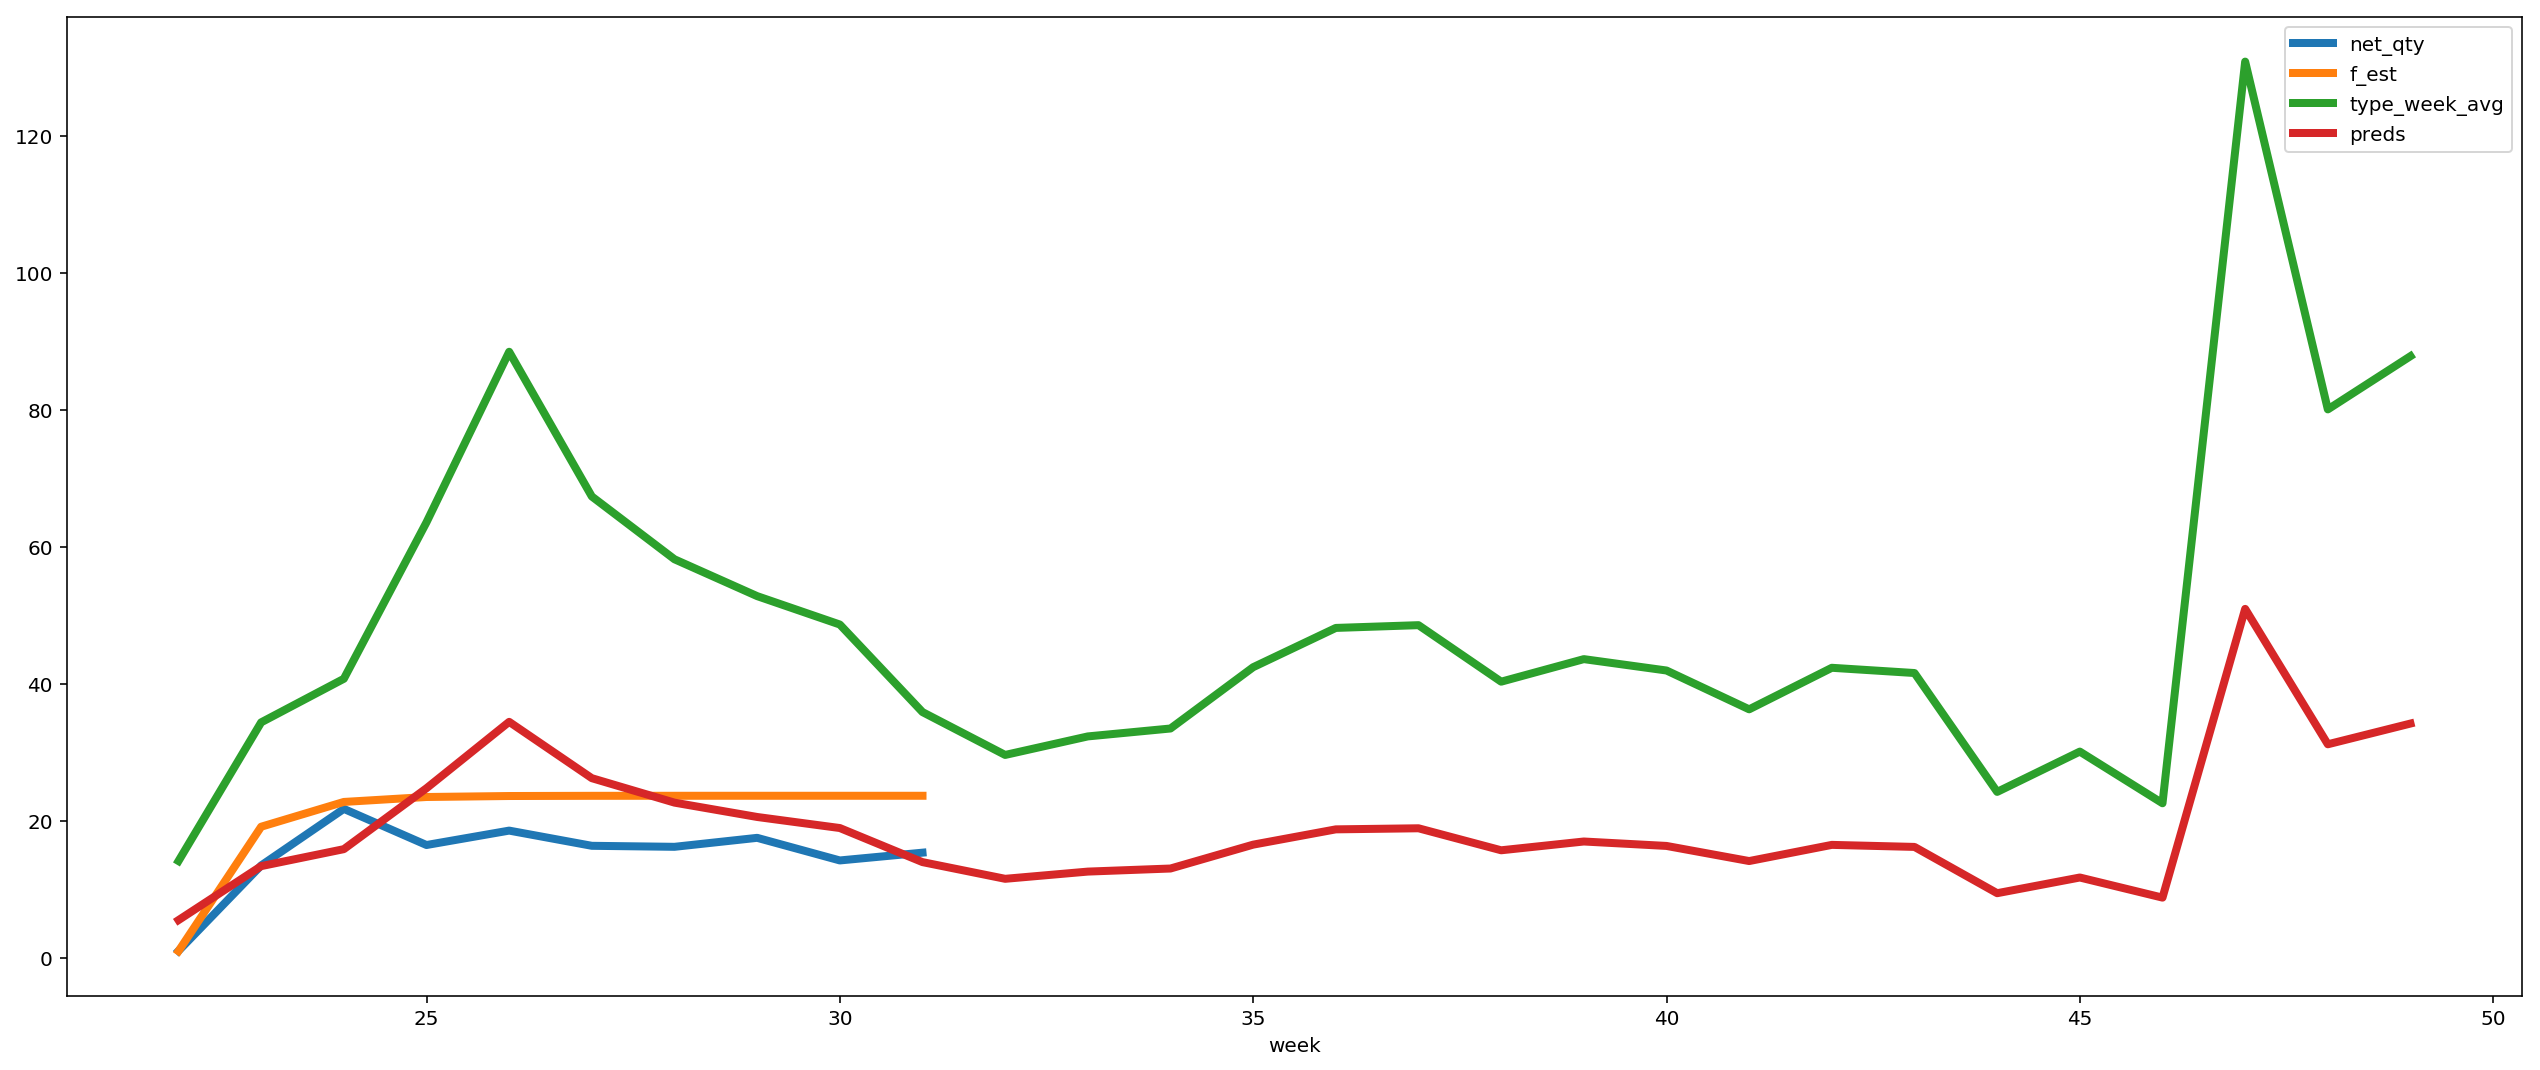

In [361]:
#   --- CHOOSE RANDOM ARTICLE TO PLOT---
a = np.random.choice(dat_FW19.article_number.unique(), size = 1, replace = False)[0]
dat_a = dat_FW19[dat_FW19.article_number == a]
#   ---- ---- ---- ---- ---- ---- 
dat_a.set_index(['week'], inplace = True)

plt.rcParams["figure.figsize"] = [22,9]
dat_a[['net_qty', 'f_est', 'type_week_avg', 'preds']].plot(linewidth = 4)

# RED (preds) is GREEN's (article type weekly avg) prediction of ORANGE (GAS)

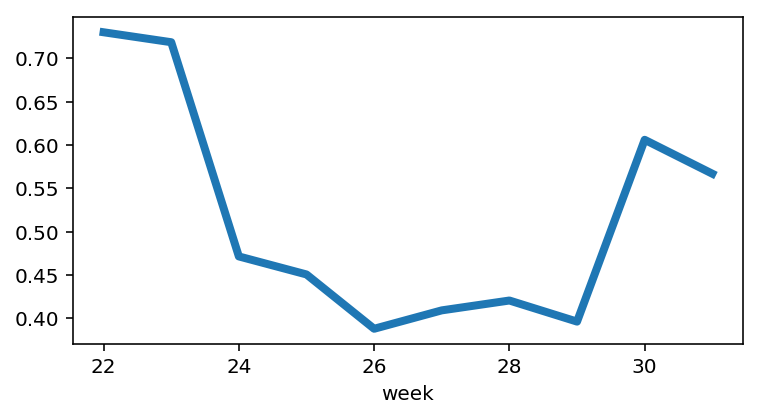

In [360]:
plt.rcParams["figure.figsize"] = [6, 3]
dat_a['buy_availability'].plot(linewidth = 4)

In [ ]:
# pivoted = dat_SS19.pivot_table(values = 'type_week_avg',
#                               index = ['year', 'week'],
#                               columns = 'article_number')

# plt.rcParams["figure.figsize"] = [22,9]
# pivoted.plot(linewidth = 4)


# Appendix

In [ ]:

# # ---- Add cost ----
# cost_price = pd.read_csv('Cost Price.csv', low_memory=False, index_col = 0)
# cost_price.rename(columns = {'avg(cost_of_sales)': 'cost'}, inplace = True)
# cost_price = pd.DataFrame(cost_price['cost'].groupby(cost_price.index).mean()).round()


In [ ]:
# dat.drop(['plant', 'warehouse'], axis = 1, inplace=True)

# dat.buy_availability = dat.buy_availability.round(2)

# dat.drop_duplicates(['article_number', 'consumer_order_date'], inplace = True)

# dat[dat.duplicated()]

In [ ]:
# len(set(dat2[dat2.season == 'FW18'].article_number).intersection(set(dat2[dat2.season == 'FW19'].article_number)))


In [ ]:
# ref_dat.head()

# pd.crosstab(index = ref_dat['rmh_product_type_descr'], columns = 'count')

# for c in ref_dat.columns:
#     d = ref_dat[c].unique()
#     print('***', c, '***', d)

In [ ]:
# ref_dat = pd.read_csv('data/dat_ref.csv', low_memory = False, index_col = 0,
#                      usecols = ['group_article', 'price_band', 'age_group_descr', 
#                                 'brand_descr', 'sub_brand_descr',
#                                 'rmh_retail_department_descr', 'rmh_category_descr', 'rmh_gender_descr',
#                                 'rmh_retail_section_descr', 'rmh_product_division_descr',
#                                 'rmh_product_type_descr', 'product_franchise_descr'])

# ref_dat2 = pd.read_csv('data/Article reference data.csv', low_memory = False, index_col = 0, error_bad_lines = False,
#                       usecols = ['model_no', 'key_cat_desc', 'sports_cat_desc', 'rmh_cat_desc', 
#                                  'prod_div_desc', 'prod_grp_desc', 'prod_type_desc']                      
#                       )



In [ ]:

pivoted = d.pivot(index = 'consumer_order_date', columns = 'article_number', values = 'buy_availability')

plt.rcParams["figure.figsize"] = [18,6]

pivoted.plot(linewidth = 4)
plt.title('Buy Availability Over Time')
plt.ylabel('Buy Availability')


In [ ]:
import statsmodels.api as sm

mod = sm.OLS(article_s.y, article_s.X, missing='drop') # y = article, x = seasonality
mod_res = mod.fit()

mod_res.summary()

article_s['seasonal_impute'] = mod_res.predict()

In [ ]:
# --- Merge learning ----
# dat_two_articles = dat_FW19[dat_FW19.article_number.isin(['019000', 'AA0040'])]

# seasonality_two_types = seasonality[seasonality.prod_type_desc.isin(['FOOTBALL SHOES (INDOOR)', 'PANTS (1/1)'])]

# article_weeks = pd.DataFrame(
#     [(a, w) for a in merge_test.article_number.unique() for w in range(22, 50)]
# ).rename(columns = {0: 'article_number', 1: 'week'})

# dat_two_articles_all_weeks = pd.merge(merge_test, article_weeks, how = 'outer').sort_values(['article_number', 'year', 'week'])

# pd.merge(mt4, merge_test2, how = 'outer', on=['prod_type_desc', 'week'])

In [ ]:
# ref_dat0 = pd.read_csv('data/dat_ref.csv', low_memory = False, index_col = 0,
#                      usecols = ['group_article', 'price_band', 'age_group_descr', 
#                                 'brand_descr', 'sub_brand_descr',
#                                 'rmh_retail_department_descr', 'rmh_category_descr', 'rmh_gender_descr',
#                                 'rmh_retail_section_descr', 'rmh_product_division_descr',
#                                 'rmh_product_type_descr', 'product_franchise_descr'])